In [1]:
import math
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

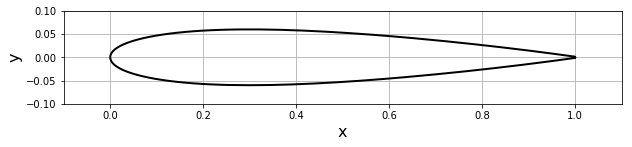

In [2]:
x,y=numpy.loadtxt('naca0012.dat', unpack= True )
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

In [3]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)
        
        if xb - xa <= 0.0:
            self.beta = math.acos((yb - ya)/self.length)
        else:
            self.beta = math.pi + math.acos(-(yb - ya)/self.length)
            
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
            
        self.sigma = 0.0
        self.vt = 0.0
        self.cp = 0.0

In [4]:
def air_panel(x,y, N_panel):
    R = (x.max() - x.min())/2
    x_center = (x.max() + x.min())/2
    x_circle = x_center + R * numpy.cos(numpy.linspace(0,2*math.pi, N_panel+1))
    
    x_ends = numpy.copy(x_circle)
    y_ends = numpy.zeros_like(x_ends)
    
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    I=0
    for i in range(N_panel):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    panels = numpy.empty(N_panel, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

In [5]:
N=40
panels = air_panel(x, y, N)

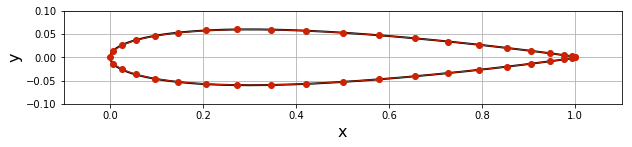

In [6]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

In [8]:
class Freestream:
    
    def __init__(self, u_inf, alpha):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)
    
u_inf = 1.0             
alpha = 0.0                            
freestream = Freestream(u_inf, alpha)

In [9]:
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [16]:
def source_contribution_normal(panels):
   
    A = numpy.empty((panels.size, panels.size), dtype=float)

    numpy.fill_diagonal(A, 0.5)
   
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

In [17]:
def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    
    numpy.fill_diagonal(A, 0.0)
    
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A
    

In [18]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)